# Import data and packages


In [71]:
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from matplotlib import pyplot
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from scipy import stats
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import time
%matplotlib inline


data = pd.read_csv("datasets_483_982_spam.csv",encoding = 'latin-1')
data.dropna(how = 'any',inplace = True,axis = 1) #remove NA column
data.columns = ['label', 'body_text'] # Add column name
data.head()

,label,body_text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Data Exploration

### 1.How many spam/ham in the dataset? 

In [72]:
print('There are {} spam, there are {} ham.'.format(len(data[data['label'] == 'spam']),
                                                   len(data[data['label'] == 'ham'])))

There are 747 spam, there are 4825 ham.


Text(0.5, 1.0, 'number of ham vs spam txt')

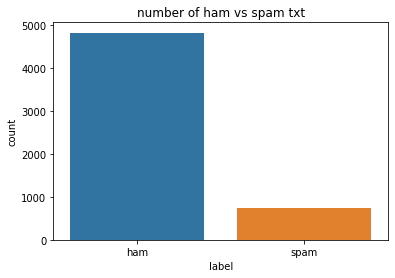

In [73]:
sns.countplot(data.label)
pyplot.title('number of ham vs spam txt')

### 2.Shape of the dataset?

In [74]:
print('The dataset has {} rows and {} columns'.format(len(data), len(data.columns)))

The dataset has 5572 rows and 2 columns


### 3.What is the length for spam and what is the length for ham?

In [75]:
data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
data.head()

,label,body_text,body_len
0,ham,"Go until jurong point, crazy.. Available only ...",92
1,ham,Ok lar... Joking wif u oni...,24
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128
3,ham,U dun say so early hor... U c already then say...,39
4,ham,"Nah I don't think he goes to usf, he lives aro...",49


/Users/hhuang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/hhuang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


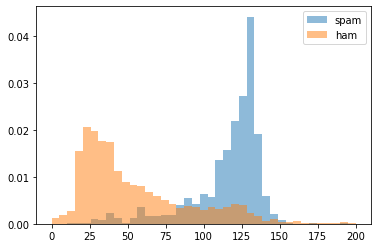

In [76]:
bins = np.linspace(0, 200, 40)

pyplot.hist(data[data['label']=='spam']['body_len'], bins, alpha=0.5, normed=True, label='spam')
pyplot.hist(data[data['label']=='ham']['body_len'], bins, alpha=0.5, normed=True, label='ham')
pyplot.legend(loc='upper right')
pyplot.show()
# From the histogram, we can tell the spam txt have longer body length then ham txt. 
# For ham length, the distribution is skewed right. For spam, the distribution is skewed left.
#In our mahcine learning model we should include this feature to distinguish ham and spam.

### 4. What is percentage of punctuation in spma/ham txt?

In [77]:
def punct_perc(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 4)*100
data['punct_percentage'] = data['body_text'].apply(lambda x: punct_perc(x))
data.head()

,label,body_text,body_len,punct_percentage
0,ham,"Go until jurong point, crazy.. Available only ...",92,9.78
1,ham,Ok lar... Joking wif u oni...,24,25.00
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.69
3,ham,U dun say so early hor... U c already then say...,39,15.38
4,ham,"Nah I don't think he goes to usf, he lives aro...",49,4.08


/Users/hhuang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/hhuang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


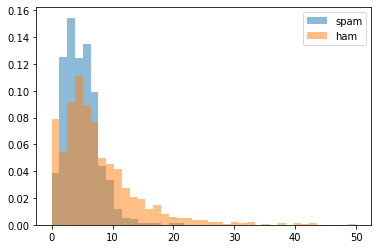

In [78]:
bins = np.linspace(0, 50, 40)

pyplot.hist(data[data['label']=='spam']['punct_percentage'], bins, alpha=0.5, normed=True, label='spam')
pyplot.hist(data[data['label']=='ham']['punct_percentage'], bins, alpha=0.5, normed=True, label='ham')
pyplot.legend(loc='upper right')
pyplot.show()
# There is no much difference for spam and ham when considering punctuation percentage.

### 5. Words map for spam txt

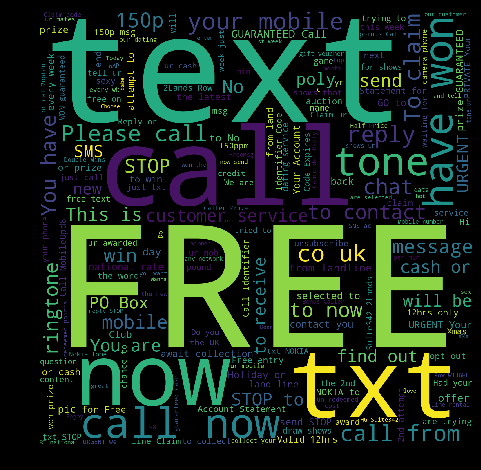

In [79]:
spam_w = " ".join(list(data[data['label'] == 'spam']['body_text']))
spam_wc = WordCloud(width = 1500,height = 1500).generate(spam_w)
pyplot.figure(figsize = (10,8),facecolor = 'k')
pyplot.imshow(spam_wc)
# for spam, most used words are 'free','text','call',tec.

### 6. Words map for ham txt

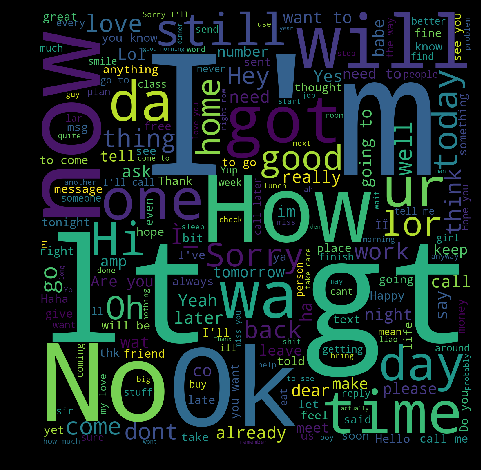

In [80]:
ham_w = " ".join(list(data[data['label'] == 'ham']['body_text']))
ham_wc = WordCloud(width = 1500,height = 1500).generate(ham_w)
pyplot.figure(figsize = (10,8),facecolor = 'k')
pyplot.imshow(ham_wc)
# for ham, most used words are 'I'm','no','ok',etc.

# Data Process 

### Remove punctuation,tokenization, remove stopwords

In [81]:
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

def text_new(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split("\W+",text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text



### Vectorization by using tfidf

In [82]:
tfidf_vect = TfidfVectorizer(analyzer=text_new)
X_tfidf = tfidf_vect.fit_transform(data['body_text'])

X_features = pd.concat([data['body_len'], data['punct_percentage'], pd.DataFrame(X_tfidf.toarray())], axis=1)
X_features.head()

,body_len,punct_percentage,0,1,2,3,4,5,6,7,...,8050,8051,8052,8053,8054,8055,8056,8057,8058,8059
0,92,9.78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24,25.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,128,4.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,39,15.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,49,4.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Check body length and punctuation percentage distribution

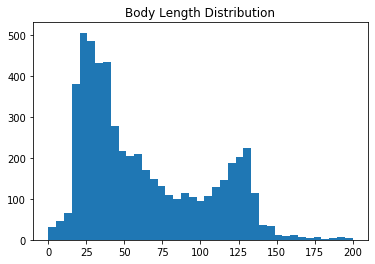

In [83]:
#For body length
bins = np.linspace(0,200,40)

pyplot.hist(data['body_len'],bins)
pyplot.title('Body Length Distribution')
pyplot.show()

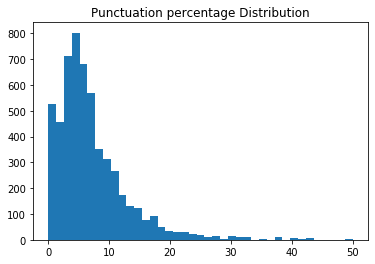

In [84]:
# for punctuation percentage
bins = np.linspace(0,50,40)

pyplot.hist(data['punct_percentage'],bins)
pyplot.title('Punctuation percentage Distribution') #heavily skewed
pyplot.show()


([array([  9.,   7.,  17.,  10.,  15.,  17.,  50.,  56.,  53.,  69., 183.,
         158., 203., 258., 277., 255., 391., 409., 324., 348., 296., 340.,
         324., 211., 201., 155., 152.,  98.,  64.,  43.,  30.,  34.,  14.,
          16.,   4.,   1.,  10.,   0.,   0.,   2.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.])],
 array([-0.30349453, -0.19362319, -0.08375185,  0.02611949,  0.13599083,
         0.24586217,  0.35573351,  0.46560485,  0.57547619,  0.68534753,
         0.79521887,  0.90509021,  1.01496155,  1.12483289,  1.23470423,
         1.34457557,  1.45444691,  1.56431825,  1.67418959,  1.78406093,
         1.89393227,  2.00380361,  2.11367495,  2.22354629,  2.33341763,
         2.44328898,  2.55316032,  2.66303166,  2.772903  ,  2.88277434,
         2.99264568,  3.10251702,  3.21238836,  3.3222597 ,  3.43213104,
         3.54200238, 

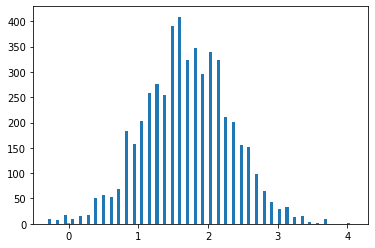

In [85]:
#Use Box_cox transformation
punct_bc = stats.boxcox(X_features[X_features['punct_percentage'] > 0]['punct_percentage'])
pyplot.hist(punct_bc,bins = 40)
#After the transformation, the data is normally distributed now.

# Fit classification ML models

## Random Forest 


In [20]:
#divide train and test dataset by 75/25
x_train,x_test,y_train,y_test = train_test_split(X_features, data['label'],test_size = 0.25)                                                                           

In [23]:
#train the model
rf = RandomForestClassifier(n_estimators = 30,max_depth = 20,n_jobs = -1)
rf_model = rf.fit(x_train,y_train)

In [27]:
# fit test dataset into the model
y_pred = rf_model.predict(x_test)
precision, recall, fscore, support = score(y_test, y_pred, pos_label='spam', average='binary')
print(precision, recall)

1.0 0.576530612244898


In [28]:
#Accuracy
print((y_pred==y_test).sum() / len(y_pred))

0.9404163675520459


## Improve Random Forest model performace by using Grid-search

In [32]:
def train_RF(n_est, depth):
    rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, n_jobs=-1)
    rf_model = rf.fit(x_train, y_train)
    y_pred = rf_model.predict(x_test)
    precision, recall, fscore, support = score(y_test, y_pred, pos_label='spam', average='binary')
    print('Est: {} / Depth: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
        n_est, depth, round(precision, 3), round(recall, 3),
        round((y_pred==y_test).sum() / len(y_pred), 3)))

In [33]:
for n_est in [10, 50, 100]:
    for depth in [10, 20, 30, None]:
        train_RF(n_est, depth)

Est: 10 / Depth: 10 ---- Precision: 1.0 / Recall: 0.352 / Accuracy: 0.909
Est: 10 / Depth: 20 ---- Precision: 1.0 / Recall: 0.617 / Accuracy: 0.946
Est: 10 / Depth: 30 ---- Precision: 0.993 / Recall: 0.694 / Accuracy: 0.956
Est: 10 / Depth: None ---- Precision: 0.969 / Recall: 0.786 / Accuracy: 0.966
Est: 50 / Depth: 10 ---- Precision: 1.0 / Recall: 0.276 / Accuracy: 0.898
Est: 50 / Depth: 20 ---- Precision: 1.0 / Recall: 0.551 / Accuracy: 0.937
Est: 50 / Depth: 30 ---- Precision: 1.0 / Recall: 0.724 / Accuracy: 0.961
Est: 50 / Depth: None ---- Precision: 1.0 / Recall: 0.842 / Accuracy: 0.978
Est: 100 / Depth: 10 ---- Precision: 1.0 / Recall: 0.224 / Accuracy: 0.891
Est: 100 / Depth: 20 ---- Precision: 1.0 / Recall: 0.571 / Accuracy: 0.94
Est: 100 / Depth: 30 ---- Precision: 1.0 / Recall: 0.704 / Accuracy: 0.958
Est: 100 / Depth: None ---- Precision: 1.0 / Recall: 0.821 / Accuracy: 0.975


number of estimator is 50 and depth is None give us most accuracy random forest model.The accuracy is 0.978

# Gradient Boosting model

In [40]:
#train the model
gb = GradientBoostingClassifier(n_estimators = 100, max_depth = 10, learning_rate = 0.1)
gb_model = gb.fit(x_train,y_train)

In [41]:
# fit test dataset into the model
y_pred = gb_model.predict(x_test)
precision, recall, fscore, support = score(y_test, y_pred, pos_label='spam', average='binary')
#Accuracy
print((y_pred==y_test).sum() / len(y_pred))

0.968413496051687


## Improve Gradient Boosting model performace by using Grid-search

In [45]:
def train_GB(est, max_depth, lr):
    gb = GradientBoostingClassifier(n_estimators=est, max_depth=max_depth, learning_rate=lr)
    gb_model = gb.fit(x_train, y_train)
    y_pred = gb_model.predict(x_test)
    precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
    print('Est: {} / Depth: {} / LR: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
        est, max_depth, lr, round(precision, 3), round(recall, 3), 
        round((y_pred==y_test).sum()/len(y_pred), 3)))

In [46]:
for n_est in [75, 100, 125]:
    for max_depth in [5,10, 15]:
        for lr in [0.01, 0.1, 0.5]:
            train_GB(n_est, max_depth, lr)

Est: 75 / Depth: 5 / LR: 0.01 ---- Precision: 0.941 / Recall: 0.566 / Accuracy: 0.934
Est: 75 / Depth: 5 / LR: 0.1 ---- Precision: 0.921 / Recall: 0.837 / Accuracy: 0.967
Est: 75 / Depth: 5 / LR: 0.5 ---- Precision: 0.938 / Recall: 0.852 / Accuracy: 0.971
Est: 75 / Depth: 10 / LR: 0.01 ---- Precision: 0.966 / Recall: 0.714 / Accuracy: 0.956
Est: 75 / Depth: 10 / LR: 0.1 ---- Precision: 0.898 / Recall: 0.857 / Accuracy: 0.966
Est: 75 / Depth: 10 / LR: 0.5 ---- Precision: 0.913 / Recall: 0.857 / Accuracy: 0.968
Est: 75 / Depth: 15 / LR: 0.01 ---- Precision: 0.928 / Recall: 0.786 / Accuracy: 0.961
Est: 75 / Depth: 15 / LR: 0.1 ---- Precision: 0.919 / Recall: 0.867 / Accuracy: 0.971
Est: 75 / Depth: 15 / LR: 0.5 ---- Precision: 0.932 / Recall: 0.837 / Accuracy: 0.968
Est: 100 / Depth: 5 / LR: 0.01 ---- Precision: 0.948 / Recall: 0.648 / Accuracy: 0.945
Est: 100 / Depth: 5 / LR: 0.1 ---- Precision: 0.932 / Recall: 0.842 / Accuracy: 0.969
Est: 100 / Depth: 5 / LR: 0.5 ---- Precision: 0.928 /

The number of estimat is 125, depth is 15 and Learing rate is 0.5 gives us best gradient boosting model. The accuracy is 0.976. 

# Model Selection

## When we do the model selection, we need to consider business context.
### 1.Predict time: for most spam classification, time is a very crucial. There is some trade-off between time and accuracy.
### 2.Precision vs Recall: different business model need different optimization model.

### random Forest Final model

In [66]:
#train the model
rf = RandomForestClassifier(n_estimators = 50,max_depth = None,n_jobs = -1)


In [67]:
st = time.time()
rf_model = rf.fit(x_train, y_train)
ed = time.time()
fit_time = (ed - st)

st = time.time()
y_pred = rf_model.predict(x_test)
ed = time.time()
pred_time = (ed - st)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Fit time: {} / Predict time: {}' .format(fit_time, pred_time))
print('Precision: {} / Accuracy: {}'.format(precision,(y_pred==y_test).sum() / len(y_pred)))

Fit time: 0.9273171424865723 / Predict time: 0.17391467094421387
Precision: 1.0 / Accuracy: 0.9741564967695621


### Gradient Boosting final model

In [68]:
#train the model
gb = GradientBoostingClassifier(n_estimators = 125, max_depth = 15, learning_rate = 0.5)


In [69]:
st = time.time()
gb_model = gb.fit(x_train, y_train)
ed = time.time()
fit_time = (ed - st)

st = time.time()
y_pred = gb_model.predict(x_test)
ed = time.time()
pred_time = (ed - st)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Fit time: {} / Predict time: {}' .format(fit_time, pred_time))
print('Precision: {} / Accuracy: {}'.format(precision,(y_pred==y_test).sum() / len(y_pred)))

Fit time: 85.24263191223145 / Predict time: 0.09903621673583984
Precision: 0.9388888888888889 / Accuracy: 0.9727207465900933


### For spam classification, we want to increase precision which is the total number of predicted as Spam that are actuanlly spam divided by total number of predicted as spam.  We pick random forest as our fianl model.